In [151]:
import networkx as nx
import pandas as pd
import numpy as np
import geopandas as gpd
import osmnx as ox
from shapely.geometry import LineString, Point
from shapely.ops import linemerge
from copy import deepcopy #seems like Networkx does shallow copies by default

import momepy as mm

from datetime import datetime
import matplotlib.pyplot as plt

# Consolidating Intersections

In [97]:
dist_threshold=30 #parameter to consolidate intersections. This has different meanings depending on whether we use OSMnx or the network way, will be clarified

## 1. Collecting Data

In [98]:
point = 40.432996, -3.691383 #Madrid
dist = 500

In [99]:
graph = ox.graph_from_point(point, dist=dist,
                            network_type='drive', simplify=True)
graph_proj = ox.project_graph(graph)
graph_proj_und = ox.get_undirected(graph_proj)

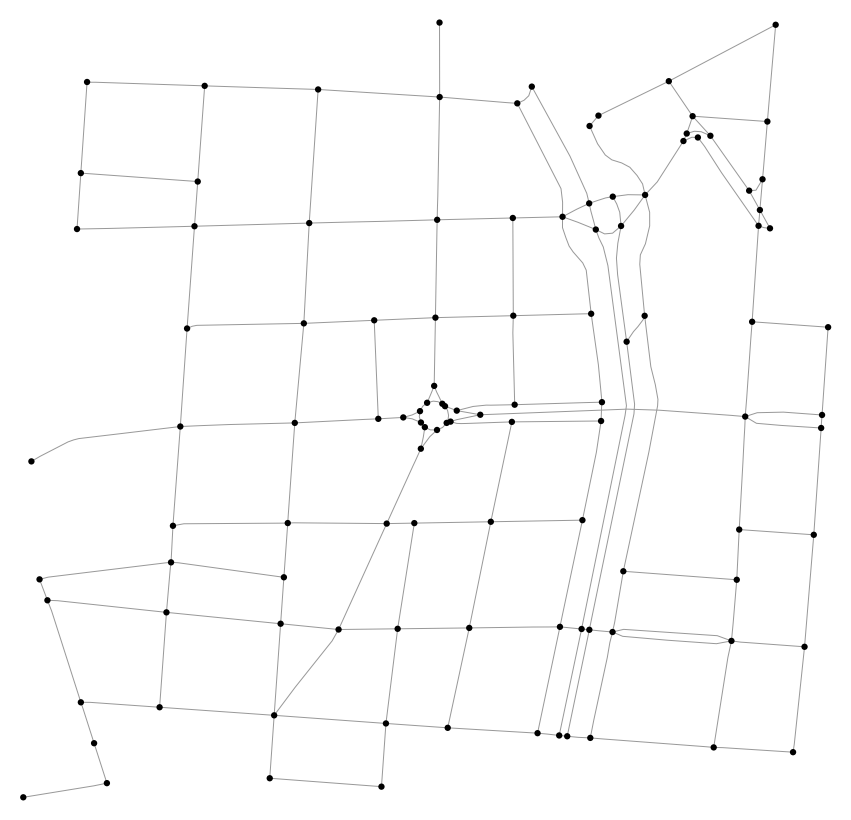

In [100]:
fig, ax = ox.plot_graph(graph_proj_und, figsize=(15,15), node_color='k', node_size=40, bgcolor='white')
plt.show()

## 2. Baseline OSMNx function

I will compare my results to the consolidate intersection functions from the simplify module in osmnx:

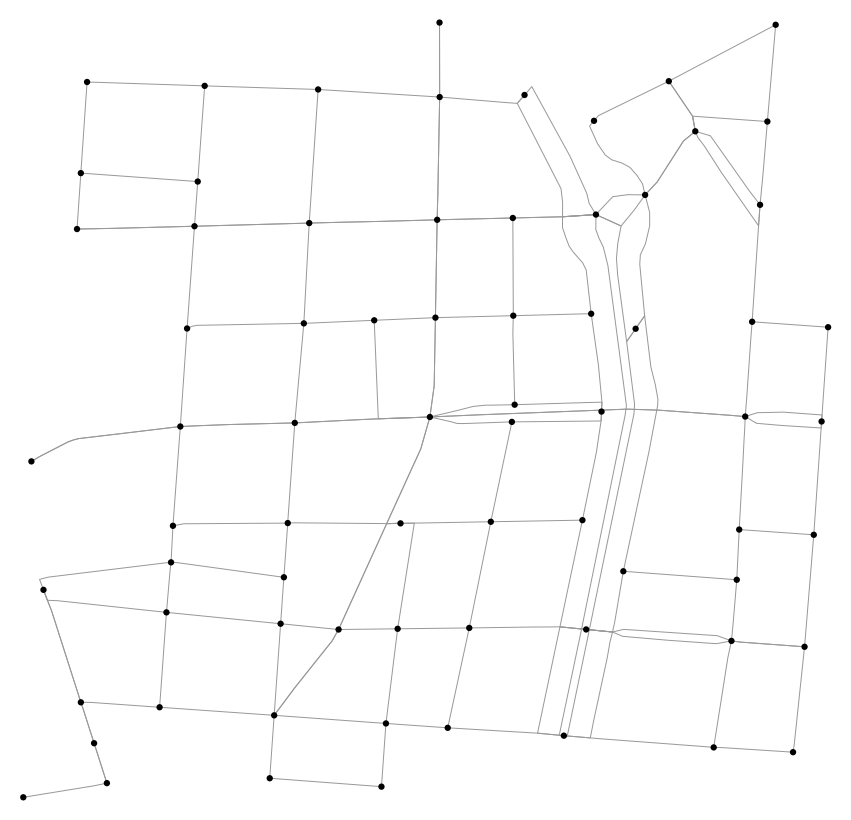

In [101]:
graph_cons = ox.simplification._consolidate_intersections_rebuild_graph(graph_proj, tolerance=dist_threshold*(2/3))
fig, ax = ox.plot_graph(graph_cons, figsize=(15,15), node_color='k', node_size=40, bgcolor='white')
plt.show()

The function does not work for undirected graphs

## 3. Assessing Network components directly

We will use the graph nodes throughout. It will be easier to have them as a dataframe.

In [102]:
nodes, nodes_dict = zip(*graph_proj_und.nodes(data=True))
nodes_df = pd.DataFrame(nodes_dict, index=nodes)
nodes_gdf = gpd.GeoDataFrame(nodes_df, crs=graph_proj_und.graph['crs'], geometry=gpd.points_from_xy(nodes_df['x'], nodes_df['y']))

Rather than buffering nodes to check proximity and then checking whether the nodes are connected, we can check if the nodes are connected in the graph directly. A way of doing so is to first remove all edges longer than our connectivity threshold, and then discard the isolated nodes. The remaining graph components are precisely the independent node clusters:

In [103]:
components_graph = deepcopy(graph_proj_und)
components_graph.remove_edges_from([edge for edge in graph_proj_und.edges(keys=True, data=True) if edge[-1]['length'] > dist_threshold])
isolated_nodes_list = list(nx.isolates(components_graph))
components_graph.remove_nodes_from(isolated_nodes_list)

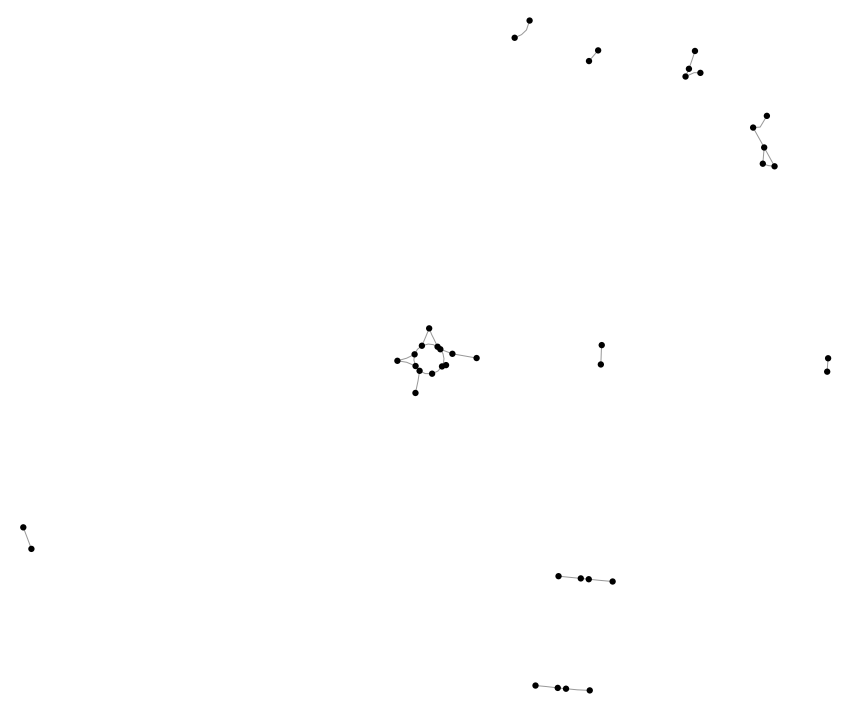

In [104]:
fig, ax = ox.plot_graph(components_graph, figsize=(15,15), node_color='k', node_size=40, bgcolor='white')
plt.show()

The connected components of this graph are node clusters we must individually simplify. We collect them in a dataframe and retrieve node properties (x, y coords mainly) from the original graph. Note that such function is very useful because it independently identifies which groups of nodes need some sort of simplification. In a later improvement---for folks who want a better simplification function---we could classify such groups and do tailored simplification e.g. for roundabouts, for bridges.

In [105]:
components_dict = dict(enumerate(nx.connected_components(components_graph), start=max(nodes)+1))
nodes_to_merge_dict = {node: cpt for cpt, nodes in components_dict.items() for node in nodes}
nodes_to_merge_df = pd.concat([pd.DataFrame.from_dict(nodes_to_merge_dict, orient='index', columns=['cluster']), nodes_df[['x', 'y']]],
                                  axis=1, join='inner')

Each cluster can be represented as the centroid of its members. We average the x and y attributes in every cluster:

In [106]:
cluster_centroids_df = nodes_to_merge_df.groupby('cluster').mean()
cluster_centroids_df['simplified'] = True
cluster_centroids_df['original_osmids'] = cluster_centroids_df.index.map(components_dict)
cluster_nodes_list = list(cluster_centroids_df.to_dict('index').items())

We can begin to create our simplified graph. First, we copy the original graph and replace the collapsed nodes with the centroids:

In [107]:
simplified_graph = deepcopy(graph_proj_und)
simplified_graph.remove_nodes_from(nodes_to_merge_df.index) #removing nodes also removes edges!
simplified_graph.add_nodes_from(cluster_nodes_list)

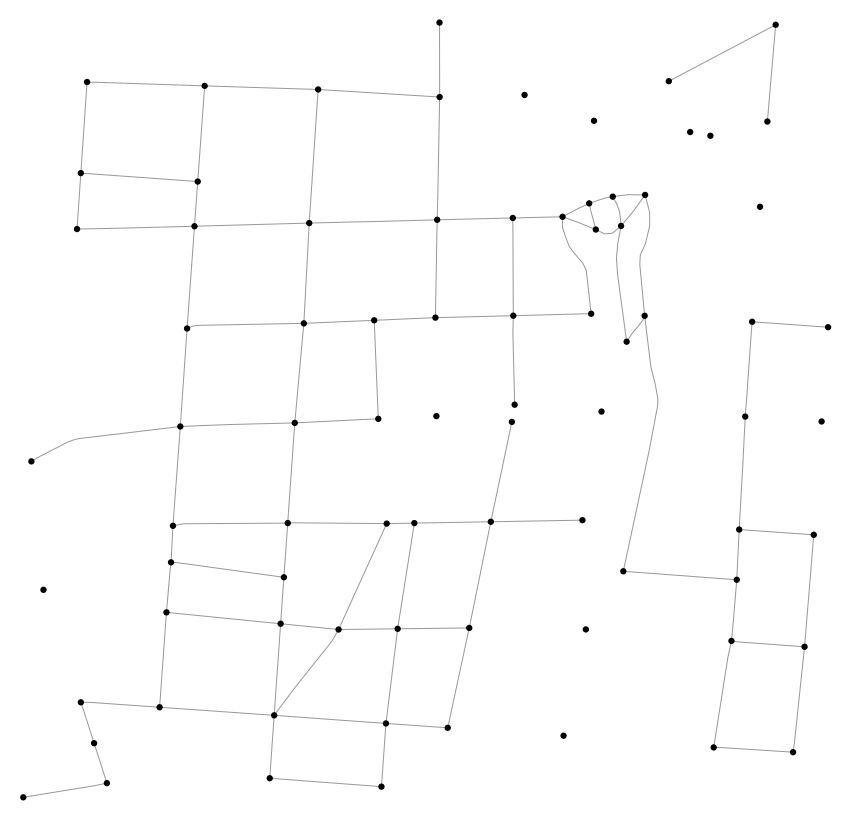

In [108]:
fig, ax = ox.plot_graph(simplified_graph, figsize=(15,15), node_color='k', node_size=40, bgcolor='white')
plt.show()

### 3.a. Rebuilding edges

Now we must rebuild the edges. This is by far the trickiest part. There many ways this can be done:

1. We do not do it. In OSMNx, user can select "rebuild_graph=False". Then the graph is retrieved with nodes only. This is useful for folks studying node properties, but has little application to morphology. (in such case, we also didn't need the edge gdf)
2. Connect nodes to the clusters via an "unapologethic straight line" i.e. as the crow flies. This ignores any pre-existing geometry indication. This is the fastest "reconnection method" and, most importantly, it preserves adjacency. For folks studying network properties (degree distribution, random walks, motif analysis) that do not rely in the edge geometry, this is ideal.
3. Connect nodes to the clusters via an estimation of what the simplified edge would look like. This is more laborous and subjective. Two ways of doing so are (i) to extend the line from the original collapsed node to the centroid and (ii) to crop the line a little bit before the original collapsed node and then extend it to the centroid. The first is a "linear" reconstruction, where the latter is more of a "spider web" reconstruction. 

To begin, we need the edge GeoDataFrame:

In [155]:
edges_gdf = mm.nx_to_gdf(graph_proj_und, points=False, lines=True)

Using our mapping of nodes to clusters, we create a column with OD clusters and find their geometry:

In [110]:
edges_gdf['origin_cluster'] = edges_gdf['from'].apply(lambda u: nodes_to_merge_dict[u] if u in nodes_to_merge_dict else -1)
edges_gdf['destination_cluster'] = edges_gdf['to'].apply(lambda v: nodes_to_merge_dict[v] if v in nodes_to_merge_dict else -1)

cluster_centroids_df['geometry'] = gpd.points_from_xy(cluster_centroids_df.x, cluster_centroids_df.y, crs=graph.graph['crs'])
edges_gdf['new_origin_pt'] = edges_gdf.origin_cluster.map(cluster_centroids_df.geometry, None)
edges_gdf['new_destination_pt'] = edges_gdf.destination_cluster.map(cluster_centroids_df.geometry, None)

We select what edges need to be simplified. Those are of three kinds:

1. Edges between two different cluster centroids
2. Edges between an unchanged node and a cluster centroid
3. Self-loops on a cluster centroid

In [111]:
edges_gdf.query("origin_cluster != destination_cluster or ((to == 'from') and origin_cluster >= 0)", inplace=True)

For now, let's focus on the edge estimation with linear simplification:

In [92]:
def linear_simplification(geometry, new_origin, new_destination):
    """
    Rebuilds edge giving (potential) new origin and destinations through a linear method: current line is linearly extended
     to and from the new endpoints.
     
    :param geometry: shapely.LineString, current edge
    :param new_origin: shapely.Point or None, new origin point or None if origin remains the same
    :param new_destination: shapely.Point or None, new destination point or None if destination remains the same
    
    return shapely.LineString
    """
    #If we are dealing with a self-loop the line has no endpoints:
    if new_origin == new_destination: 
        current_node = Point(line_coords[0])
        geometry = linemerge([LineString([new_origin, current_node]), geometry])
    #Assuming the line is not closed, we can find its endpoints:
    else:
        current_origin, current_destination = geometry.boundary
        if new_origin is not None:
            geometry = linemerge([LineString([new_origin, current_origin]), geometry])
        if new_destination is not None:
            geometry = linemerge([geometry, LineString([current_destination, new_destination])])
    return geometry

edges_gdf['new_geometry'] = edges_gdf.apply(lambda edge: linear_simplification(edge.geometry, edge.new_origin_pt, edge.new_destination_pt), axis=1)

We can now polish the edge geodataframe by updating the columns that require update:

In [132]:
edges_gdf.reset_index(inplace=True)
edges_gdf.rename({'from':'original_from', 'to':'original_to',
                  'origin_cluster':'from', 'destination_cluster':'to',
                  'geometry':'original_geometry', 'new_geometry':'geometry'},
                  axis=1, inplace=True)
edges_gdf.drop(columns=['new_origin_pt', 'new_destination_pt'], inplace=True)
edges_gdf['length'] = edges_gdf['geometry'].apply(lambda x: x.length)

#Update the indices:
edges_gdf['from'].where(edges_gdf['from']>=0, edges_gdf['original_from'], inplace=True)
edges_gdf['to'].where(edges_gdf['to']>=0, edges_gdf['original_to'], inplace=True)

Networkx requires new edges to be passed as a list with (u,v data_dict):

In [133]:
new_edges_list = list(zip(edges_gdf['from'], edges_gdf['to'], edges_gdf.iloc[:, 2:].to_dict('index').values()))

We update the graph:

In [134]:
new_graph = simplified_graph.add_edges_from(new_edges_list)

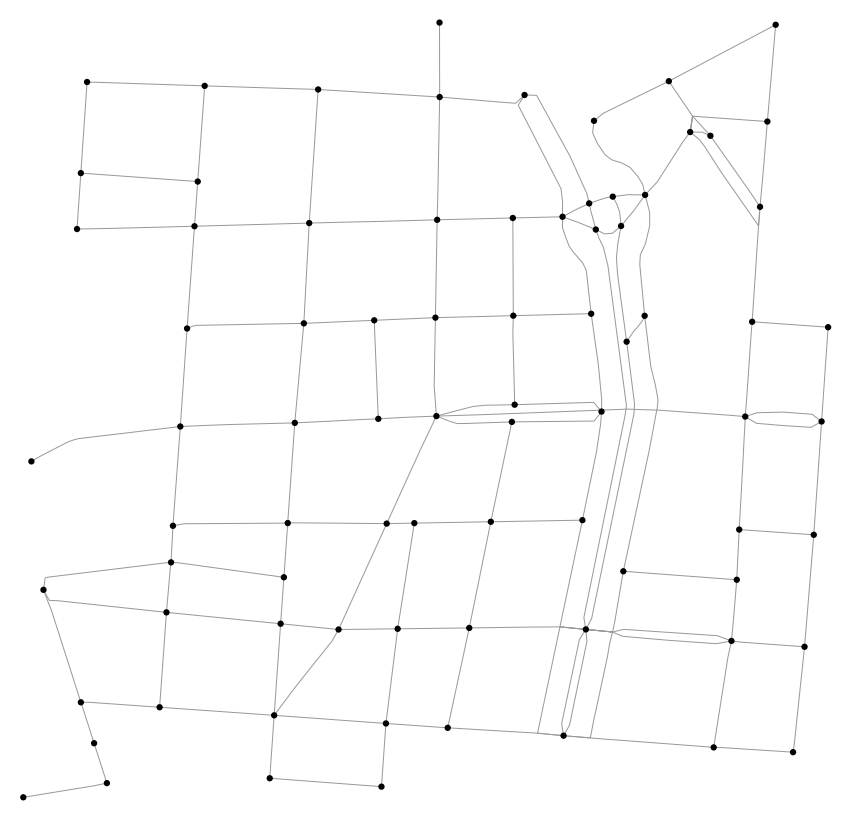

In [135]:
fig, ax = ox.plot_graph(simplified_graph, figsize=(15,15), node_color='k', node_size=40, bgcolor='white')
plt.show()

Note how the roundabout was simplified well, and there was no planarity assumption so the bridge was not merged to the node below it. However, edges do not reflect the simplification that well: the vertical two lane street in the middle-right of the plot has only one intersection but seemingly two edges. We can think of better means of simplification (averaging the lines, spider web) for those specific cases.

### 3b. Putting it together:

We can put it all in a function. I will use the parameters that match the OSMnx function when possible:

In [22]:
ox.consolidate_intersections?

Signature:
ox.consolidate_intersections(
    G,
    tolerance=10,
    rebuild_graph=True,
    dead_ends=False,
    reconnect_edges=True,
)
Docstring:
Consolidate intersections comprising clusters of nearby nodes.

Merges nearby nodes and returns either their centroids or a rebuilt graph
with consolidated intersections and reconnected edge geometries. The
tolerance argument should be adjusted to approximately match street design
standards in the specific street network, and you should always use a
projected graph to work in meaningful and consistent units like meters.

When rebuild_graph=False, it uses a purely geometrical (and relatively
fast) algorithm to identify "geometrically close" nodes, merge them, and
return just the merged intersections' centroids. When rebuild_graph=True,
it uses a topological (and slower but more accurate) algorithm to identify
"topologically close" nodes, merge them, then rebuild/return the graph.
Returned graph's node IDs represent clusters rather than osm

So far I will ignore the dead ends consideration. Beyond whether to rebuild edges, if passed True, user must specify the method they want to use for rebuilding. Could be linear, crow_flies, or spider. Further method should incluse averaging edges in two-lane streets.

In [160]:
import numpy as np
import geopandas as gpd
import pandas as pd
import networkx as nx
from copy import deepcopy

from shapely.geometry import LineString, Point
from shapely.ops import linemerge, split

def consolidate_intersections_nx(graph, tolerance=25, rebuild_graph=True, rebuild_edges_method='spider',
                                 directed=None, x_col='x', y_col='y',
                                 edge_from_col='from', edge_to_col='to'):
    """
    Consolidate close street intersections into a single node, collapsing short edges.
    
    If rebuild_graph is True, new edges are drawn according to rebuild_edges_method which is one of:
    
    1. Linear reconstruction:
        Edges are linearly extended from original endpoints until the new nodes. This method preserves
        most faithfully the network geometry.
    2. Spider-web reconstruction:
        Edges are cropped within a buffer of the new endpoints and linearly extended from there. This
        method improves upon linear reconstruction by mantaining, when possible, network planarity.
    3. As-the-crow-flies reconstruction:
        Edges are ignored and new edges are built as straightlines between new origin and new
        destination. This method ignores geometry, but efficiently preserves adjacency.
    
    If rebuild_graph is False, graph is returned with consolidated nodes but without reconstructed 
    edges i.e. graph is intentionally disconnected.
    
    Graph must be configured so that nodes have attributes determining their x and y coordinates and
    the graph has a valid crs attribute.
    
    Parameters
    ----------
    graph : Networkx.MultiGraph or Networkx.MultiDiGraph
    
    tolerance : float
        distance in network units below which nodes will be consolidated
        
    rebuild_graph: Boolean
    
    rebuild_edges_method: string
        'spider' or 'linear' or 'crow_flies'
    
    directed: Boolean
    
    x_col, y_col: string
        node attribute with the valid coordinate
    
    edge_from_col, edge_to_col: string
        edge attribute with the valid origin/destination node id
        
    Returns
    ----------
    Networkx.MultiGraph or Networkx.MultiDiGraph
    
    """
    
    #Collect nodes and their data:
    nodes, nodes_dict = zip(*graph.nodes(data=True))
    nodes_df = pd.DataFrame(nodes_dict, index=nodes)
    nodes_gdf = gpd.GeoDataFrame(nodes_df, crs=graph.graph['crs'], geometry=gpd.points_from_xy(nodes_df[x_col], nodes_df[y_col])) #improve crs here
    
    #In case we did not specify directionality, we infer it from the network:
    if directed is None:
        directed = True if isinstance(graph, nx.MultiDiGraph) else False

    #Create a graph without the edges above a certain length and clean it from isolated nodes (the unsimplifiable nodes):
    components_graph = deepcopy(graph)
    components_graph.remove_edges_from([edge for edge in graph.edges(keys=True, data=True) if edge[-1]['length'] > tolerance])
    isolated_nodes_list = list(nx.isolates(components_graph))
    components_graph.remove_nodes_from(isolated_nodes_list)
    
    #The connected components of this graph are node clusters we must individually simplify. We collect them in a dataframe and
    #  retrieve node properties (x, y coords mainly) from the original graph.
    components_dict = dict(enumerate(nx.connected_components(components_graph), start=max(nodes)+1))
    nodes_to_merge_dict = {node: cpt for cpt, nodes in components_dict.items() for node in nodes}
    nodes_to_merge_df = pd.concat([pd.DataFrame.from_dict(nodes_to_merge_dict, orient='index', columns=['cluster']), nodes_df[[x_col, y_col]]],
                                  axis=1, join='inner')
    
    #The two node attributes we need for the clusters are the position of the cluster centroids. Those are obtained by averaging
    #  the x and y columns. We also add attribtues referring to the original osmids in every cluster:
    cluster_centroids_df = nodes_to_merge_df.groupby('cluster').mean()
    cluster_centroids_df['simplified'] = True
    cluster_centroids_df['original_osmids'] = cluster_centroids_df.index.map(components_dict)
    cluster_nodes_list = list(cluster_centroids_df.to_dict('index').items())
    
    #Rebuild edges if necessary:
    if rebuild_graph:
        graph.graph['approach'] = 'primal'
        edges_gdf = mm.nx_to_gdf(graph, points=False, lines=True)
        simplified_edges = _get_rebuilt_edges(edges_gdf, nodes_to_merge_dict, cluster_centroids_df,
                                              method=rebuild_edges_method, tolerance=tolerance,
                                              edge_from_col=edge_from_col, edge_to_col=edge_to_col)
    
    #Replacing the collapsed nodes with centroids and adding edges:
    simplified_graph = graph.copy()
    simplified_graph.remove_nodes_from(nodes_to_merge_df.index) #removing nodes also removes edges!
    simplified_graph.add_nodes_from(cluster_nodes_list)
    
    if rebuild_graph:
        simplified_graph.add_edges_from(simplified_edges)
        
    return simplified_graph

def _get_rebuilt_edges(edges_gdf, nodes_dict, cluster_df, method='linear', tolerance=30, edge_from_col='from', edge_to_col='to'):
    """
    Rebuilds edge given (potential) new origin and destinations through a linear method: current line is linearly extended
     to and from the new endpoints.
     
    :param geometry: shapely.LineString, current edge
    :param new_origin: shapely.Point or None, new origin point or None if origin remains the same
    :param new_destination: shapely.Point or None, new destination point or None if destination remains the same
    
    return list of edges in format (origin_id, destination_id, edge_data)
    """
    #Determine what endpoints were made into clusters:
    edges_gdf['origin_cluster'] = edges_gdf[edge_from_col].apply(lambda u: nodes_dict[u] if u in nodes_dict else -1)
    edges_gdf['destination_cluster'] = edges_gdf[edge_to_col].apply(lambda v: nodes_dict[v] if v in nodes_dict else -1)
    
    #Determine what edges need to be simplified (either between diff. clusters or self-loops in a cluster):
    edges_gdf.query("origin_cluster != destination_cluster or (('"+edge_to_col+"' == '"+edge_from_col+"') and origin_cluster >= 0)", inplace=True)
    
    #Determine the new point geometries (when exists):
    cluster_df['geometry'] = gpd.points_from_xy(cluster_df.x, cluster_df.y, crs=graph.graph['crs'])
    edges_gdf['new_origin_pt'] = edges_gdf.origin_cluster.map(cluster_df.geometry, None)
    edges_gdf['new_destination_pt'] = edges_gdf.destination_cluster.map(cluster_df.geometry, None)
    
    #Determine the new geometry according to the simplification method:
    if method == 'linear':
        edges_gdf['new_geometry'] = edges_gdf.apply(lambda edge: _linear_simplification(edge.geometry, edge.new_origin_pt, edge.new_destination_pt), axis=1)
    elif method == 'crow_flies':
        edges_gdf['new_geometry'] = edges_gdf.apply(lambda edge: _crowflies_simplification(edge.geometry, edge.new_origin_pt, edge.new_destination_pt), axis=1)
    elif method == 'spider':
        edges_gdf['new_geometry'] = edges_gdf.apply(lambda edge: _spider_simplification(edge.geometry, edge.new_origin_pt, edge.new_destination_pt, 1.5*tolerance), axis=1)
        
    #Rename and update the columns:
    edges_gdf.reset_index(inplace=True)
    edges_gdf.rename({edge_from_col:'original_from',
                      edge_to_col:'original_to',
                      'origin_cluster':edge_from_col,
                      'destination_cluster':edge_to_col,
                      'geometry':'original_geometry',
                      'new_geometry':'geometry'},
                      axis=1,
                      inplace=True)
    edges_gdf.drop(columns=['new_origin_pt', 'new_destination_pt'], inplace=True)
    edges_gdf['length'] = edges_gdf['geometry'].apply(lambda x: x.length)
    
    #Update the indices:
    edges_gdf[edge_from_col].where(edges_gdf[edge_from_col]>=0, edges_gdf['original_from'], inplace=True)
    edges_gdf[edge_to_col].where(edges_gdf[edge_to_col]>=0, edges_gdf['original_to'], inplace=True)
    
    #Get the edge list with (from, to, data):
    new_edges_list = list(zip(edges_gdf[edge_from_col], edges_gdf[edge_to_col], edges_gdf.iloc[:, 2:].to_dict('index').values()))
    
    return new_edges_list

def _linear_simplification(geometry, new_origin, new_destination):
    """
    Rebuilds edge given (potential) new origin and destinations through a linear method: current line is linearly extended
     to and from the new endpoints.
     
    :param geometry: shapely.LineString, current edge
    :param new_origin: shapely.Point or None, new origin point or None if origin remains the same
    :param new_destination: shapely.Point or None, new destination point or None if destination remains the same
    
    return shapely.LineString
    """
    #If we are dealing with a self-loop the line has no endpoints:
    if new_origin == new_destination: 
        current_node = Point(line_coords[0])
        geometry = linemerge([LineString([new_origin, current_node]), geometry])
    #Assuming the line is not closed, we can find its endpoints:
    else:
        current_origin, current_destination = geometry.boundary
        if new_origin is not None:
            geometry = linemerge([LineString([new_origin, current_origin]), geometry])
        if new_destination is not None:
            geometry = linemerge([geometry, LineString([current_destination, new_destination])])
    return geometry

def _spider_simplification(geometry, new_origin, new_destination, buff=15):
    """
    Rebuilds edge giving (potential) new origin and destinations through a spide-web method: current line is broken within
     small buffer from new endpoint and linearly extended.
     
    :param geometry: shapely.LineString, current edge
    :param new_origin: shapely.Point or None, new origin point or None if origin remains the same
    :param new_destination: shapely.Point or None, new destination point or None if destination remains the same
    
    return shapely.LineString
    """
    #If we are dealing with a self-loop the line has no boundary and we just use the first coordinate:
    if new_origin == new_destination:
        current_node = Point(line_coords[0])
        geometry = linemerge([LineString([new_origin, current_node]), geometry])
    #Assuming the line is not closed, we can find its endpoints via the boundary attribute:
    else:
        current_origin, current_destination = geometry.boundary
        if new_origin is not None:
            #Create a buffer around the new origin:
            new_origin_buffer = new_origin.buffer(buff)
            #Use shapely.ops.split to break the edge where it intersects the buffer:
            geometry_split_by_buffer_list = list(split(geometry, new_origin_buffer))
            #If only one geometry results, edge does not intersect buffer and line should connect new origin to old origin simply.
            if len(geometry_split_by_buffer_list) == 1:
                geometry_split_by_buffer = geometry_split_by_buffer_list[0]
                splitting_point = current_origin
            #If more than one geometry, merge all linestrings but the first and get their origin
            else:
                geometry_split_by_buffer = linemerge(geometry_split_by_buffer_list[1:])
                splitting_point = geometry_split_by_buffer.boundary[0]
            #Merge this into new geometry:
            geometry = linemerge([LineString([new_origin, splitting_point]), geometry_split_by_buffer])
        if new_destination is not None:
            #Create a buffer around the new destination:
            new_destination_buffer = new_destination.buffer(buff)
            #Use shapely.ops.split to break the edge where it intersects the buffer:
            geometry_split_by_buffer_list = list(split(geometry, new_destination_buffer))
            #If only one geometry results, edge does not intersect buffer and line should connect new destination to old destination simply.
            if len(geometry_split_by_buffer_list) == 1:
                geometry_split_by_buffer = geometry_split_by_buffer_list[0]
                splitting_point = current_destination
            #If more than one geometry, merge all linestrings but the last and get their destination
            else:
                geometry_split_by_buffer = linemerge(geometry_split_by_buffer_list[:-1])
                splitting_point = geometry_split_by_buffer.boundary[1]
            #Merge this into new geometry:
            geometry = linemerge([geometry_split_by_buffer, LineString([splitting_point, new_destination])])
    return geometry

def _crowflies_simplification(geometry, new_origin, new_destination):
    """
    Rebuilds edge given (potential) new origin and destinations through an as-the-crow-flies method: straight line
      between new origin and new destination replaces any old geometry.
     
    :param geometry: shapely.LineString, current edge
    :param new_origin: shapely.Point or None, new origin point or None if origin remains the same
    :param new_destination: shapely.Point or None, new destination point or None if destination remains the same
    
    return shapely.LineString
    """
    #If we are dealing with a self-loop, the as the crow-flies geometry will be null!
    if new_origin == new_destination:
        geometry = None
    #Assuming the line is not closed, we can find its endpoints:
    else:
        current_origin, current_destination = geometry.boundary
        if new_origin is not None:
            if new_destination is not None:
                geometry = LineString([new_origin, new_destination])
            else:
                geometry = LineString([new_origin, current_destination])
        else:
            if new_destination is not None:
                geometry = LineString([current_origin, new_destination])
    return geometry

Testing:

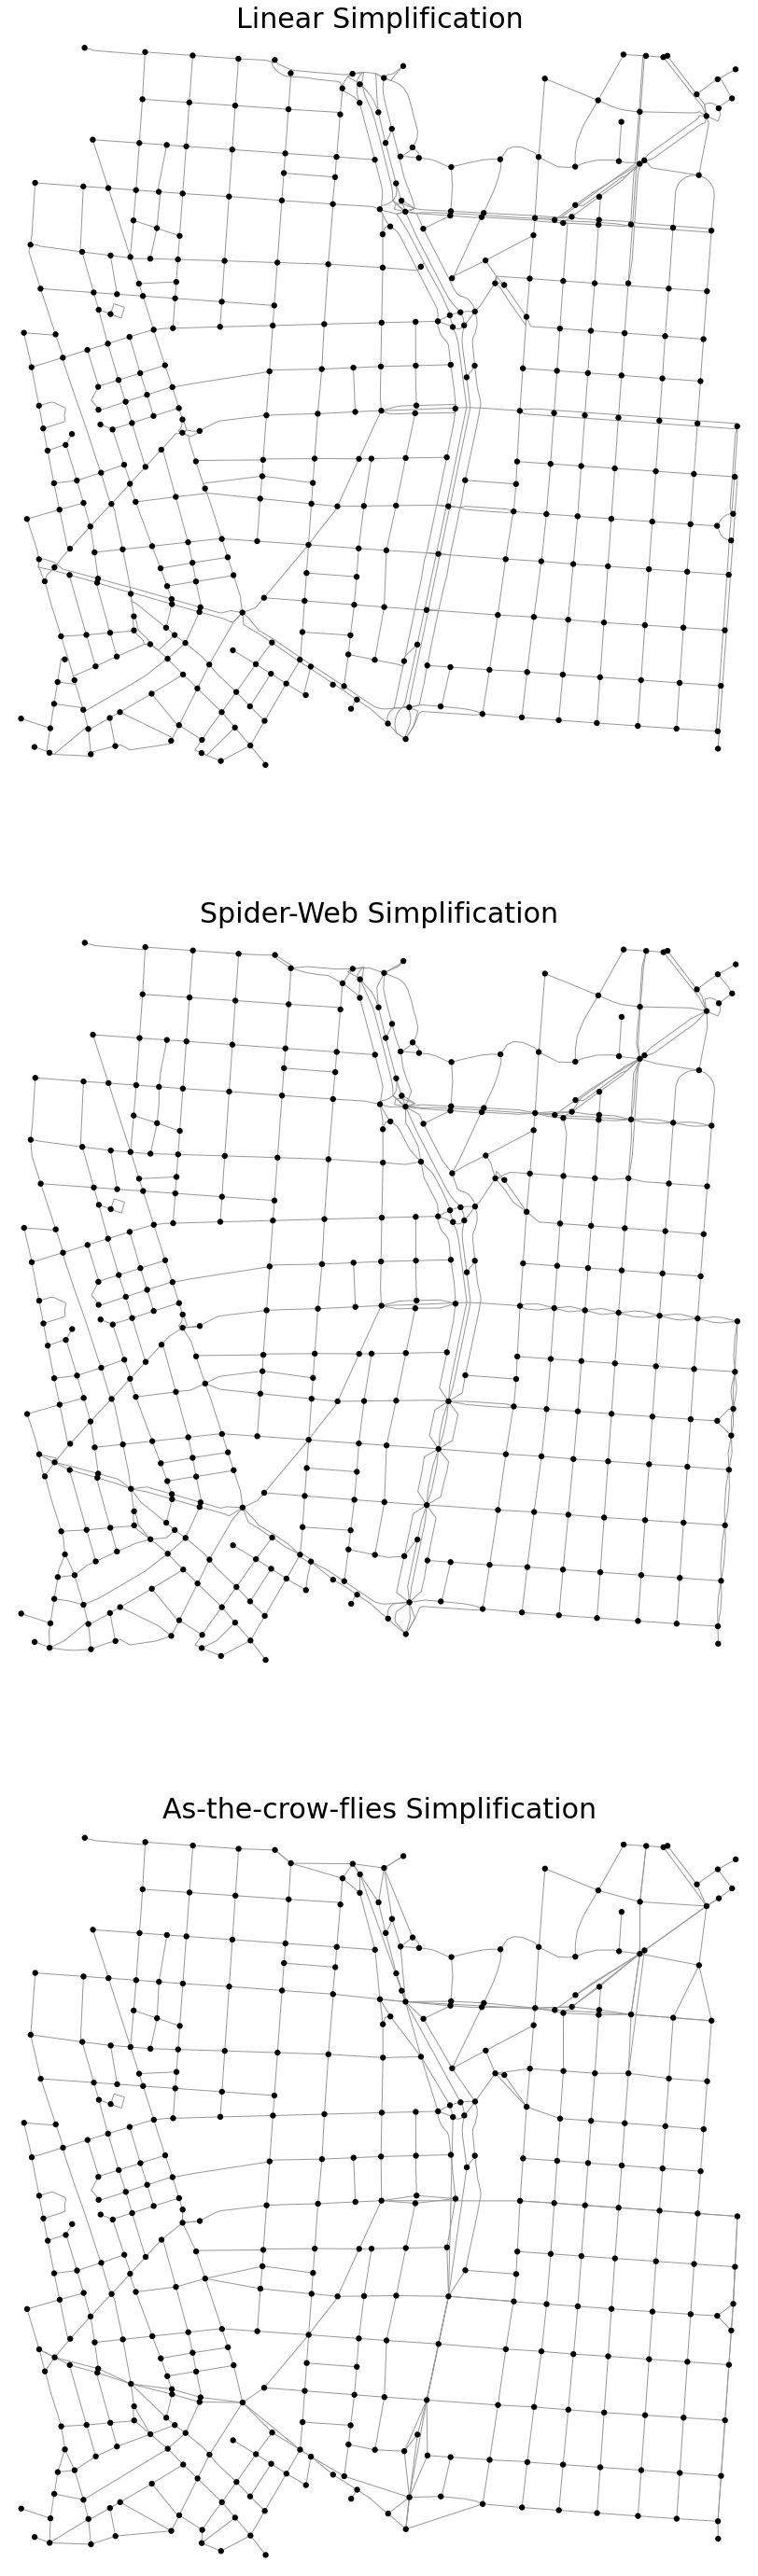

In [161]:
graph = ox.get_undirected(ox.project_graph(ox.graph_from_point(point, dist=1000, network_type='drive', simplify=True)))
fig, Axes = plt.subplots(figsize=(15,50), nrows=3)

simplified_graph_linear = consolidate_intersections_nx(graph, tolerance=30, rebuild_edges_method='linear')
fig, Axes[0] = ox.plot_graph(simplified_graph_linear, ax=Axes[0], node_color='k', node_size=40, bgcolor='white', show=False, close=False)
Axes[0].set_title('Linear Simplification', size=30)

simplified_graph_spider = consolidate_intersections_nx(graph, tolerance=30, rebuild_edges_method='spider')
fig, Axes[1] = ox.plot_graph(simplified_graph_spider, ax=Axes[1], node_color='k', node_size=40, bgcolor='white', show=False, close=False)
Axes[1].set_title('Spider-Web Simplification', size=30)

simplified_graph_crowflies = consolidate_intersections_nx(graph, tolerance=30, rebuild_edges_method='crow_flies')
fig, Axes[2] = ox.plot_graph(simplified_graph_crowflies, ax=Axes[2], node_color='k', node_size=40, bgcolor='white', show=False, close=False)
Axes[2].set_title('As-the-crow-flies Simplification', size=30)

plt.show()

The as the crow flies simplification isn't helpful for visualization, and the distances are very loose approximations. However, for purposes of adjacency computations it works perfectly fine in less time. 

# 4. Runtime comparison

Comparing runtimes first if we don't rebuild the edges:

In [25]:
for dist in [250, 500, 1000, 2000, 4000, 5000, 7500, 10000]:
    print('\n Graph radius:', dist)
    graph = ox.graph_from_point(point, dist=dist, network_type='drive', simplify=True)
    graph_proj = ox.project_graph(graph)
    graph_proj_und = ox.get_undirected(graph_proj)

    start = datetime.now()
    graph_simp_net = consolidate_intersections_nx(graph_proj_und, tolerance=30, rebuild_graph=False)
    runtime_net = datetime.now() - start
    print('Network component way:', runtime_net)

    start = datetime.now()
    graph_simp_osmnx = ox.consolidate_intersections(graph_proj, tolerance=30, rebuild_graph=False)
    runtime_ox = datetime.now() - start
    print('Osmnx way:', runtime_ox)

    print('The OSMNx way takes {0:.2f} times the runtime of the network component way'.format(runtime_ox/runtime_net, dist))


 Graph radius: 250
Network component way: 0:00:00.012816
Osmnx way: 0:00:00.012998
The OSMNx way takes 1.01 times the runtime of the network component way

 Graph radius: 500
Network component way: 0:00:00.031825
Osmnx way: 0:00:00.035661
The OSMNx way takes 1.12 times the runtime of the network component way

 Graph radius: 1000
Network component way: 0:00:00.108454
Osmnx way: 0:00:00.147055
The OSMNx way takes 1.36 times the runtime of the network component way

 Graph radius: 2000
Network component way: 0:00:00.605787
Osmnx way: 0:00:00.697583
The OSMNx way takes 1.15 times the runtime of the network component way

 Graph radius: 4000
Network component way: 0:00:01.954653
Osmnx way: 0:00:03.033758
The OSMNx way takes 1.55 times the runtime of the network component way

 Graph radius: 5000
Network component way: 0:00:03.015612
Osmnx way: 0:00:04.571907
The OSMNx way takes 1.52 times the runtime of the network component way

 Graph radius: 7500
Network component way: 0:00:05.573285
O

The network component way is slightly faster (could probably be made faster since we don't need to copy the graph!) even than the OSMNx in all cases considered.

Let's do it with crow-flies reconstruction:

In [26]:
import warnings
warnings.filterwarnings('ignore')

for dist in [250, 500, 1000, 2000, 4000, 5000, 7500, 10000]:
    print('\n Graph radius:', dist)
    graph = ox.graph_from_point(point, dist=500, network_type='drive', simplify=True)
    graph_proj = ox.project_graph(graph)
    graph_proj_und = ox.get_undirected(graph_proj)

    start = datetime.now()
    graph_simp_net = consolidate_intersections_nx(graph_proj_und, tolerance=30, rebuild_graph=True, rebuild_edges_method='crow_flies')
    runtime_net = datetime.now() - start
    print('Network component way:', runtime_net)

    start = datetime.now()
    graph_simp_osmnx = ox.consolidate_intersections(graph_proj, tolerance=30, rebuild_graph=True)
    runtime_ox = datetime.now() - start
    print('Osmnx way:', runtime_ox)

    print('The OSMNx way takes {0:.2f} times the runtime of the network component way'.format(runtime_ox/runtime_net, dist))


 Graph radius: 250
Network component way: 0:00:00.072523
Osmnx way: 0:00:00.103469
The OSMNx way takes 1.43 times the runtime of the network component way

 Graph radius: 500
Network component way: 0:00:00.063966
Osmnx way: 0:00:00.085147
The OSMNx way takes 1.33 times the runtime of the network component way

 Graph radius: 1000
Network component way: 0:00:00.062081
Osmnx way: 0:00:00.085652
The OSMNx way takes 1.38 times the runtime of the network component way

 Graph radius: 2000
Network component way: 0:00:00.073643
Osmnx way: 0:00:00.089641
The OSMNx way takes 1.22 times the runtime of the network component way

 Graph radius: 4000
Network component way: 0:00:00.065571
Osmnx way: 0:00:00.089840
The OSMNx way takes 1.37 times the runtime of the network component way

 Graph radius: 5000
Network component way: 0:00:00.061421
Osmnx way: 0:00:00.087086
The OSMNx way takes 1.42 times the runtime of the network component way

 Graph radius: 7500
Network component way: 0:00:00.071666
O

Still, the new function works faster. Now for linear method:

In [27]:
graphs_net = []
graphs_ox = []
for dist in [250, 500, 1000, 2000, 4000, 5000, 7500, 10000]:
    print('\n Graph radius:', dist)
    graph = ox.graph_from_point(point, dist=dist, network_type='drive', simplify=True)
    graph_proj = ox.project_graph(graph)
    graph_proj_und = ox.get_undirected(graph_proj)

    start = datetime.now()
    graph_simp_net = consolidate_intersections_nx(graph_proj_und, tolerance=30, rebuild_graph=True, rebuild_edges_method='linear')
    runtime_net = datetime.now() - start
    graphs_net.append(graph_simp_net)
    print('Network component way:', runtime_net)

    start = datetime.now()
    graph_simp_osmnx = ox.consolidate_intersections(graph_proj, tolerance=30, rebuild_graph=True)
    runtime_ox = datetime.now() - start
    graphs_ox.append(graph_simp_osmnx)
    print('Osmnx way:', runtime_ox)

    print('The OSMNx way takes {0:.2f} times the runtime of the network component way'.format(runtime_ox/runtime_net, dist))


 Graph radius: 250
Network component way: 0:00:00.039697
Osmnx way: 0:00:00.051070
The OSMNx way takes 1.29 times the runtime of the network component way

 Graph radius: 500
Network component way: 0:00:00.072938
Osmnx way: 0:00:00.084049
The OSMNx way takes 1.15 times the runtime of the network component way

 Graph radius: 1000
Network component way: 0:00:00.303501
Osmnx way: 0:00:00.341775
The OSMNx way takes 1.13 times the runtime of the network component way

 Graph radius: 2000
Network component way: 0:00:01.424199
Osmnx way: 0:00:01.371694
The OSMNx way takes 0.96 times the runtime of the network component way

 Graph radius: 4000
Network component way: 0:00:05.207876
Osmnx way: 0:00:05.672253
The OSMNx way takes 1.09 times the runtime of the network component way

 Graph radius: 5000
Network component way: 0:00:08.317534
Osmnx way: 0:00:12.682934
The OSMNx way takes 1.52 times the runtime of the network component way

 Graph radius: 7500
Network component way: 0:00:14.202469
O

We can plot those two graphs in columns to compare:

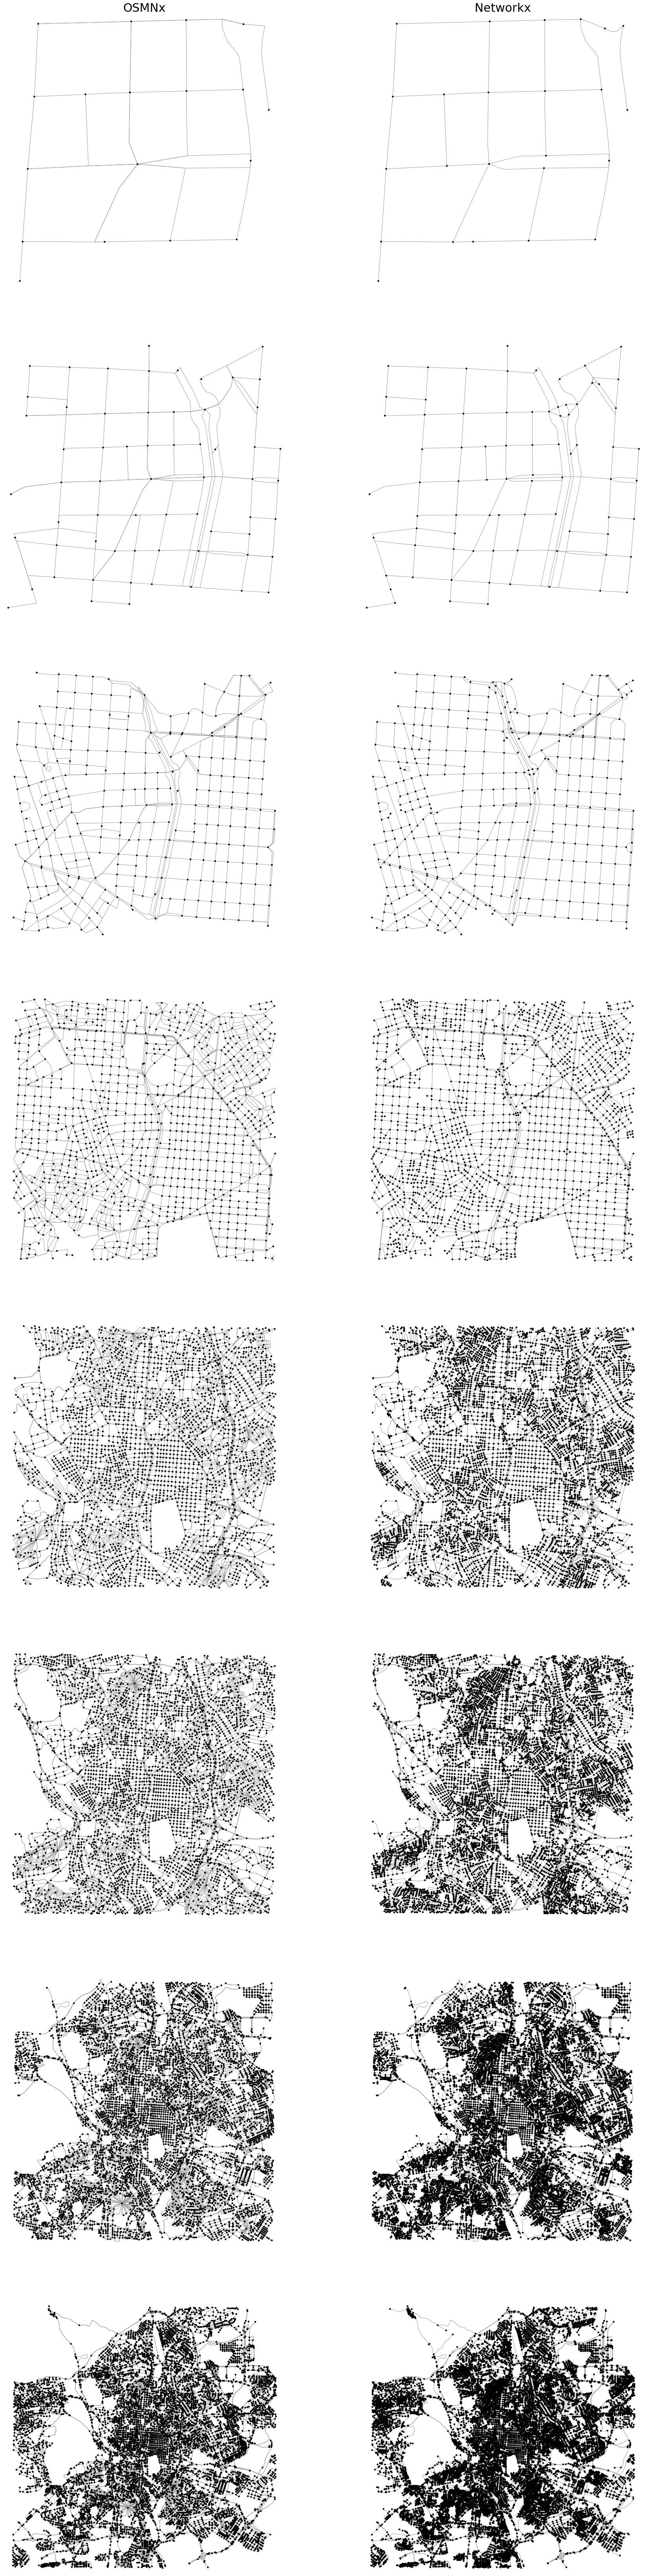

In [28]:
fig, Ax = plt.subplots(figsize=(30, 15*8), ncols=2, nrows=8)

for graph_ox, graph_nx, axes in zip(graphs_ox, graphs_net, Ax):
    fig, axes[0] = ox.plot_graph(graph_ox, ax=axes[0], node_color='k', node_size=20, bgcolor='white', show=False, close=False)
    fig, axes[1] = ox.plot_graph(graph_nx, ax=axes[1], node_color='k', node_size=20, bgcolor='white', show=False, close=False)

Ax[0,0].set_title('OSMNx', size=30)
Ax[0,1].set_title('Networkx', size=30)
plt.show()

# TO DO

Implement "average line" reconstruction. For that, we will need planarity assumption and the poligonalization of the network.